In [38]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from skimage import io, color

In [39]:
# definitions

def gaussian_2d(x, y, A=1, x0=0, y0=0, sigma=1):
    return A * np.exp(-( (x - x0)**2 / (2 * sigma**2) + (y - y0)**2 / (2 * sigma**2)))

def laplacian_2d(sigma=1):
    #scale = int(12 * sigma)
    #x, y = np.meshgrid(np.linspace(-5, 5, scale), np.linspace(-5, 5, scale))

    n = np.ceil(sigma*6)
    y,x = np.ogrid[-n//2:n//2+1,-n//2:n//2+1]

    return -(1/(np.pi*sigma**4)) * (1- ((x**2 + y**2) / (2*sigma**2))) * np.exp(-(x**2+y**2)/(2*sigma**2))

In [40]:
def draw_circles(img, blobs, cmap='CMRmap'):
    # the raius is approximate sqrt(2)*sigma

    sigma = 1
    k = np.sqrt(2)

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(img, cmap=cmap)
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r*np.sqrt(2), color='white', linewidth=2, fill=False)
        ax.add_patch(c)

    return fig, ax

In [41]:
def draw_circles_multi(img, coordinates, cmap='CMRmap'):

    fig, ax = plt.subplots(1, len(coordinates), figsize=(20, 20))
    
    for i, coordinate in enumerate(coordinates):        
        ax[i].imshow(img, cmap=cmap)
        for blob in coordinate:
            y, x, r = blob
            c = plt.Circle((x, y), r*np.sqrt(2), color='red', linewidth=1.2, fill=False)
            ax[i].add_patch(c)


    return fig, ax

In [42]:
# Read image
img = io.imread('../images/flowers.png')

# Convert to grayscale
img_gray = color.rgb2gray(img)

In [143]:
def log_image(img_gray, n_kernels=9, threshold=0.2):

    """
    :param img: input image HAS TO BE GRAYSCALE (or single channel)    
    :param min_sigma: minimum sigma value
    :param max_sigma: maximum sigma value
    :param steps: number of steps
    :return: log image        
    """

    k = np.sqrt(2)
    sigma = 1

    kernels = []
    log_images = []
    sigma_list = []    

    # threshold the log images
    log_images_thresholded = []

    for i in range(0,n_kernels):
        sigma_curr = sigma * k**i
        sigma_list.append(sigma_curr)
            
        kernel_log = laplacian_2d(sigma=sigma_curr)
        kernels.append(kernel_log)

        log_image = scipy.signal.convolve2d(img_gray, kernel_log, mode='same', boundary='symm')
        log_images.append(log_image)

        log_image_thresholded = np.zeros_like(log_images[i])
        log_image_thresholded[log_images[i] >= max(log_images[i].flatten())-(threshold * max(log_images[i].flatten()))] = 1
        log_images_thresholded.append(log_image_thresholded)
    
    log_images_np = np.array(log_images)

    return log_images_np, kernels, np.array(log_images_thresholded), sigma_list

In [144]:
def print_steps(log_images_np, kernels, log_images_thresholded, sigma_list):

    n_kernels = np.shape(log_images_np)[0]

    # plot the kernels
    fig, axs = plt.subplots(1, n_kernels, figsize=(20, 20))
    for i in range(n_kernels):
        axs[i].imshow(kernels[i], cmap='gray')        
        axs[i].set_title('σ {:.5f}'.format(sigma_list[i]))

    # plot the log images
    fig, axs = plt.subplots(1, n_kernels, figsize=(20, 20))
    for i in range(n_kernels):
        axs[i].imshow(log_images_np[i], cmap='gray')
        axs[i].set_title('σ {:.2f} max{:.2f} min{:.2f}'.format(sigma_list[i], max(log_images_np[i].flatten()), min(log_images_np[i].flatten())))

    fig, axs = plt.subplots(1, n_kernels, figsize=(20, 20))
    for i in range(np.shape(log_images_np)[0]):        
        axs[i].imshow(log_images_thresholded[i], cmap='gray')
        axs[i].set_title('σ {:.2f} max{:.2f} min{:.2f}'.format(sigma_list[i],  max(log_images_thresholded.flatten()), min(log_images_thresholded.flatten())))

    fig, axs = plt.subplots(1, np.shape(log_images_thresholded)[0], figsize=(20, 20))
    for i in range(np.shape(log_images_thresholded)[0]):
        img_test = img.copy()
        img_test[log_images_thresholded[i] == 1] = 255
        axs[i].imshow(img_test)



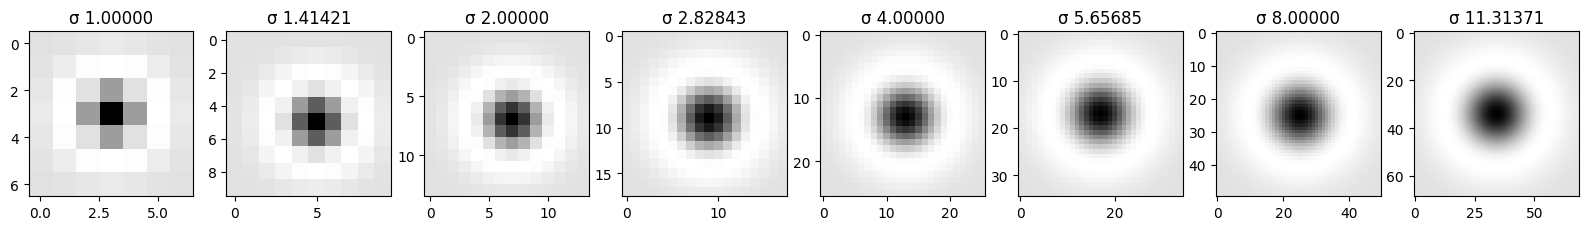

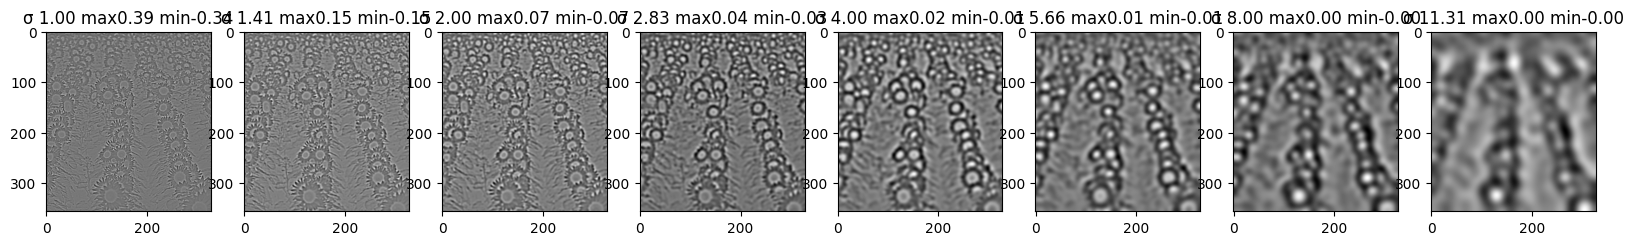

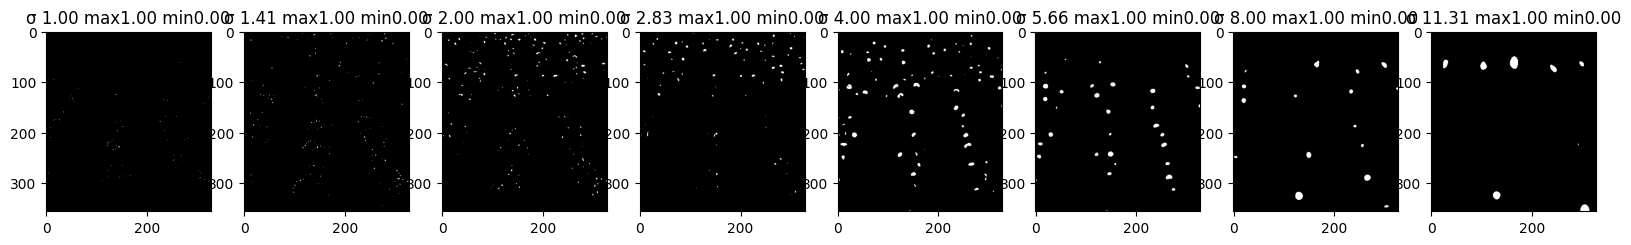

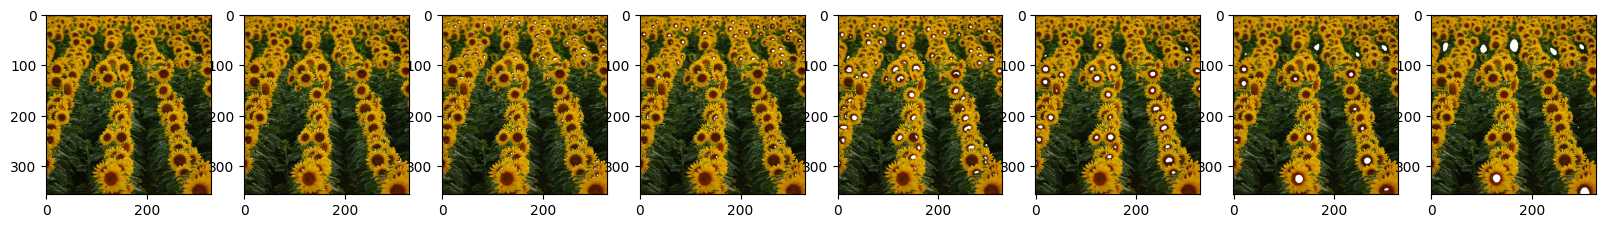

In [204]:
log_images_np, kernels, log_images_thresholded, sigma_list = log_image(img_gray, 8, threshold=0.4)

print_steps(log_images_np, kernels, log_images_thresholded, sigma_list)

(370, 370, 3)
255.0
(370, 370, 3)


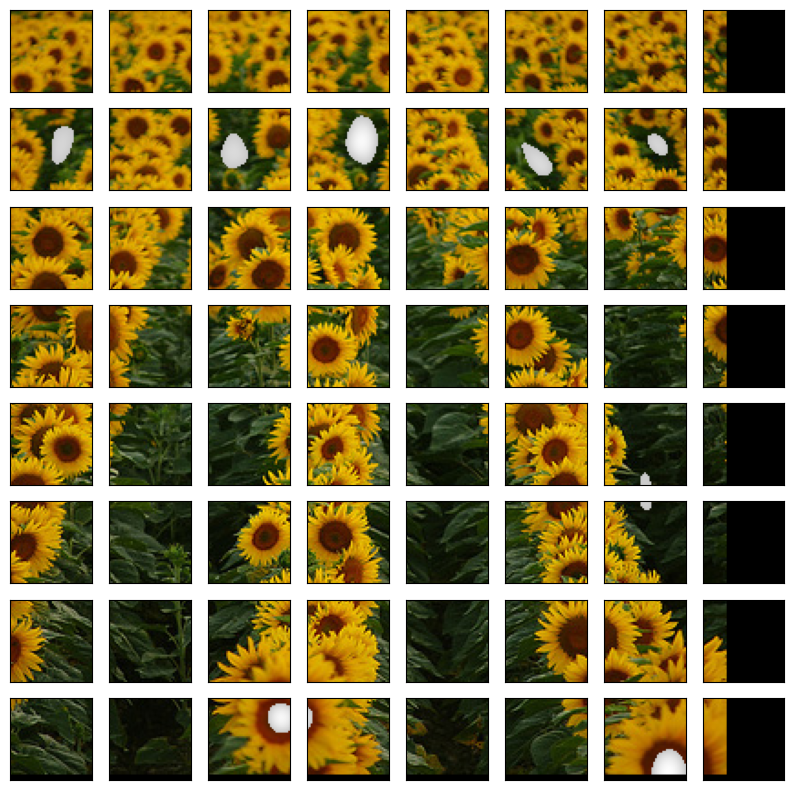

In [234]:

size = 45
padd_x = img.shape[0]%size
padd_y = img.shape[1]%size

index = 7

log_image_np = log_images_np[index].copy()

# convert log image to rgb

# convert log image to rgb
log_image_np = (log_image_np - min(log_image_np.flatten()))
log_image_np_1 = (log_image_np / max(log_image_np.flatten()))

log_image_rgb = color.gray2rgb(log_image_np_1)

img_padded = np.pad(img, ((0,padd_y),(0,padd_x),(0,0)), 'constant', constant_values=0)
log_image_thresholded_padded = np.pad(log_images_thresholded, ((0,0),(0,padd_y),(0,padd_x)), 'constant', constant_values=0)
log_image_rgb = np.pad(log_image_rgb, ((0,padd_y),(0,padd_x), (0,0)), 'constant', constant_values=0)
log_image_rgb = log_image_rgb * 255

print(log_image_rgb.shape)

print(max(log_image_rgb.flatten()))

threshold = 200

print(img_padded.shape)
fig, axs = plt.subplots(len(img_padded)//size, len(img_padded)//size, figsize=(10, 10))

for i in range(len(img_padded)//size):
    for j in range(len(img_padded)//size):
        img_test = img_padded.copy()
        img_test[log_image_rgb > threshold] = log_image_rgb[log_image_rgb > threshold]
        #axs[i].imshow(img_test)
        axs[i,j].imshow(img_test[i*size:(i+1)*size,j*size:(j+1)*size,:])
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])

    

-0.1486654121186426 0.14973399753744904
0.0 0.29839940965609163
(370, 370, 3)


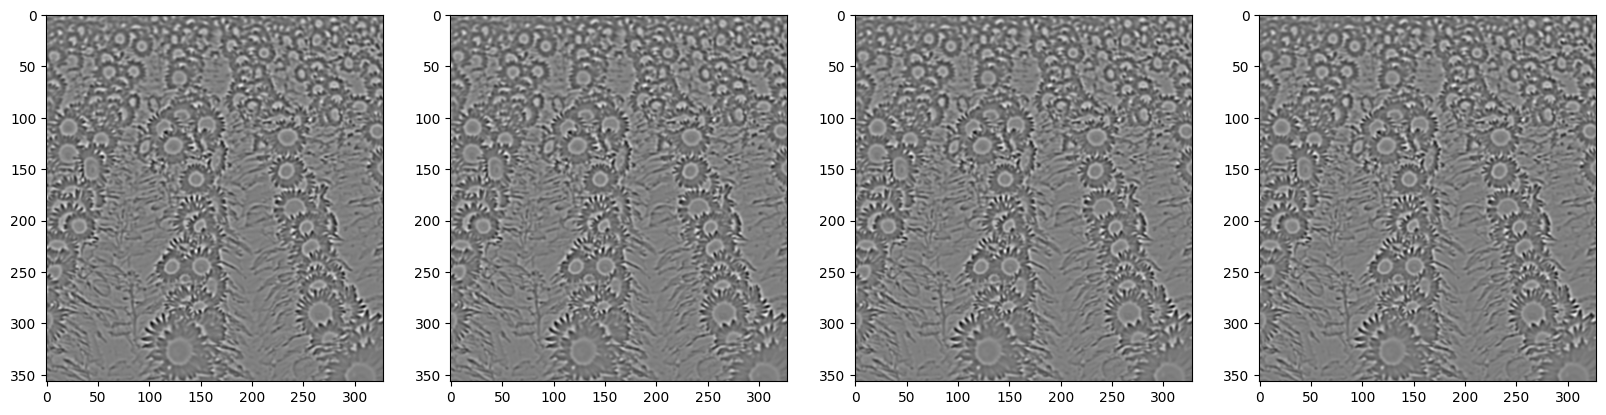

In [221]:

size = 45
padd_x = img.shape[0]%size
padd_y = img.shape[1]%size

index = 1

log_image_np = log_images_np[index].copy()

print(min(log_image_np.flatten()), max(log_image_np.flatten()))

# convert log image to rgb
log_image_np = (log_image_np - min(log_image_np.flatten()))
log_image_np_1 = (log_image_np / max(log_image_np.flatten()))
log_image_np_2 = log_image_np_1 * 255

print(min(log_image_np.flatten()), max(log_image_np.flatten()))

log_image_np_3 = color.gray2rgb(log_image_np_1)

img_padded = np.pad(img, ((0,padd_y),(0,padd_x),(0,0)), 'constant', constant_values=0)
log_image_thresholded_padded = np.pad(log_images_thresholded, ((0,0),(0,padd_y),(0,padd_x)), 'constant', constant_values=0)
#log_image_rgb = np.pad(log_image_rgb, ((0,padd_y),(0,padd_x), (0,0)), 'constant', constant_values=0)

#print(log_image_rgb.shape)

threshold = 250

print(img_padded.shape)
fig, axs = plt.subplots(1, 4, figsize=(20, 20))

axs[0].imshow(log_image_np, cmap="gray")
axs[1].imshow(log_image_np_1, cmap="gray")
axs[2].imshow(log_image_np_2, cmap="gray")
axs[3].imshow(log_image_np_3)



(370, 370, 3)


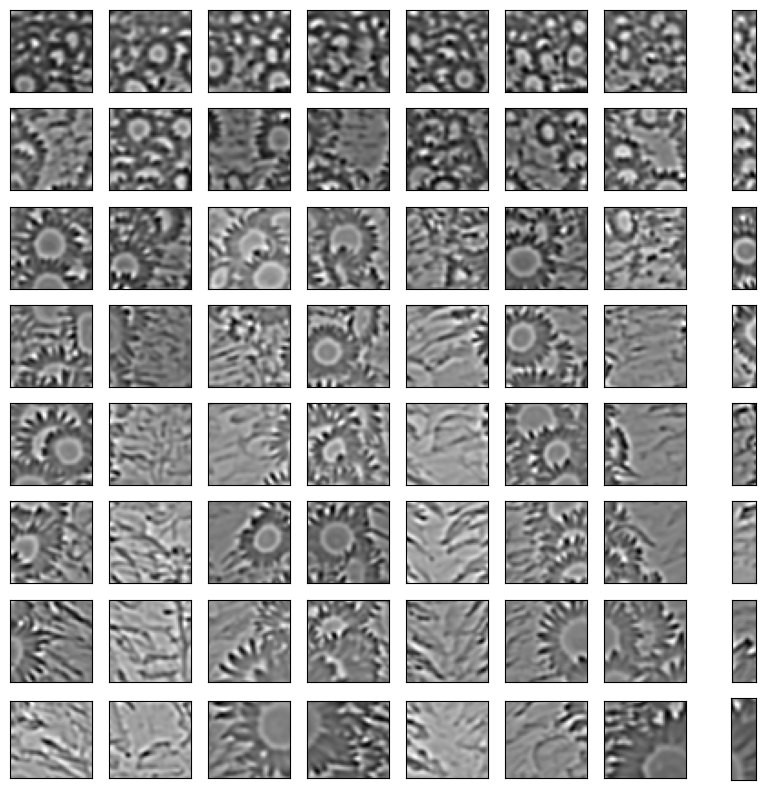

In [213]:
print(img_padded.shape)
fig, axs = plt.subplots(len(img_padded)//size, len(img_padded)//size, figsize=(10, 10))

for i in range(len(img_padded)//size):
    for j in range(len(img_padded)//size):
        #img_test = img_padded.copy()
        #img_test[log_image_rgb > threshold] = log_image_rgb[log_image_rgb > threshold]
        #axs[i].imshow(img_test)
        axs[i,j].imshow(log_image_np[i*size:(i+1)*size,j*size:(j+1)*size], cmap="gray")
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])

In [243]:
def detect_blob_v2(log_images_np, k = np.sqrt(2), sigma = 1, percentage_high = 0.5):
    co_ordinates = []    

    co_ordinates = [[] for i in range(log_images_np.shape[0])]        

    for z in range(log_images_np.shape[0]):

        size = int(np.ceil(sigma * k**z)) * 5        

        padd_y = img.shape[0]%size
        padd_x = img.shape[1]%size        

        log_images_np_padded = np.pad(log_images_np[z], ((0,padd_x),(0,padd_y)), constant_values=0)                

        (h,w) = log_images_np_padded.shape                       
        
        threshold = max(log_images_np[0].flatten())-(percentage_high * max(log_images_np[0].flatten()))

        for i in range(int(size//2),int(h-size//2), size):
            for j in range(int(size//2), int(w-size//2), size):                
                
                slice_img = log_images_np[z,i-size//2:i+size//2,j-size//2:j+size//2]                                
                x_max, y_max = np.unravel_index(np.argmax(slice_img), slice_img.shape)
                
                if slice_img[x_max, y_max] > threshold:
                    co_ordinates[z].append((i+x_max-size//2,j+y_max-size//2,(k**z)*sigma))                         

    return co_ordinates

In [244]:
coordinates = detect_blob_v2(log_images_np)

(<Figure size 2000x2000 with 8 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >], dtype=object))

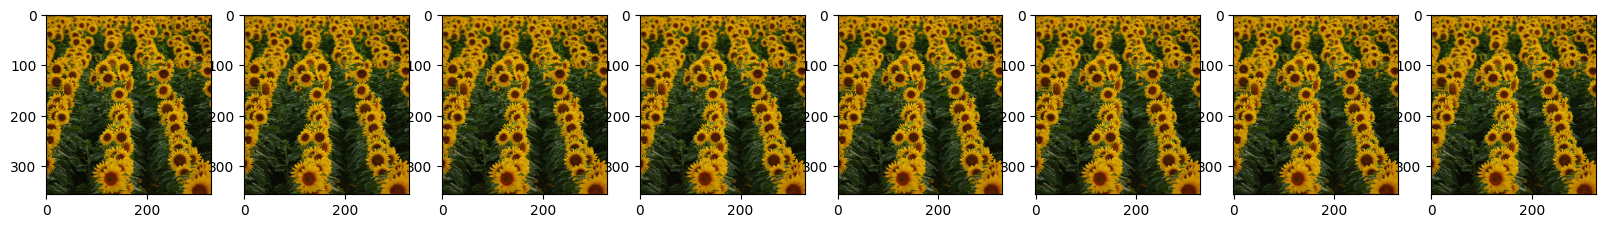

In [245]:
draw_circles_multi(img, coordinates)

In [237]:
def flatten_array_coordinates(coordinates):
    return [item for scale in coordinates for item in scale]

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

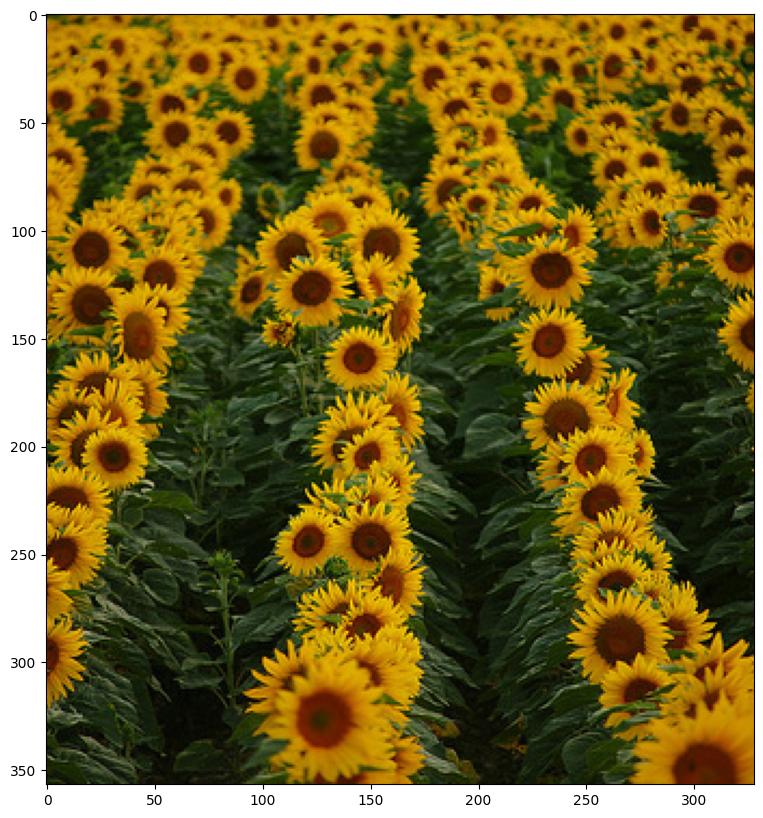

In [238]:
coordinates_1d = flatten_array_coordinates(coordinates)
draw_circles(img, coordinates_1d)

In [154]:
def non_max_suppression(coordinates, threshold = 0.8):    

    print("before", len(coordinates))

    curr_coordinates = coordinates[::-1]    

    tmp_lenght = len(curr_coordinates)

    i = 0

    while(i < tmp_lenght):
        j = i+1
        while j < tmp_lenght:            

            x1, y1, r1 = curr_coordinates[i]
            x2, y2, r2 = curr_coordinates[j]
            
            distance = np.sqrt((x1-x2)**2 + (y1-y2)**2)

            if distance < (r1+r2):
                curr_coordinates.pop(j)
                tmp_lenght -= 1
                j -= 1

            j += 1

        i += 1        

    print("after", len(curr_coordinates))

    return curr_coordinates[::-1]


In [155]:
res = non_max_suppression(coordinates_1d)


before 553
after 265


(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

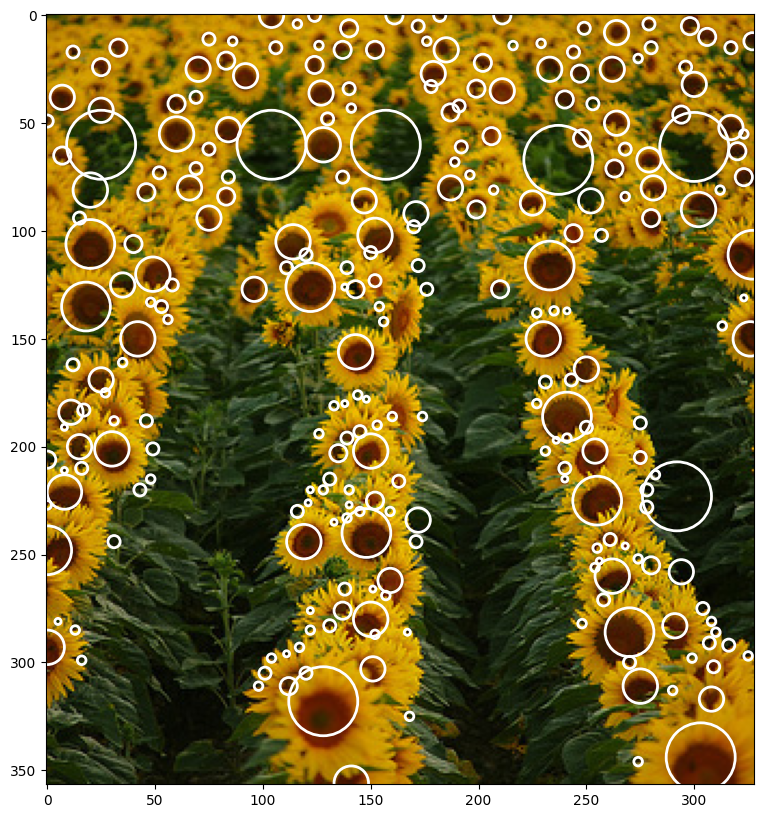

In [156]:
draw_circles(img, res)

### Other experiments with different thresholding methods

before 107
after 68
before 996
after 427
before 2590
after 1019
before 5728
after 2228


(<Figure size 2000x2000 with 4 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

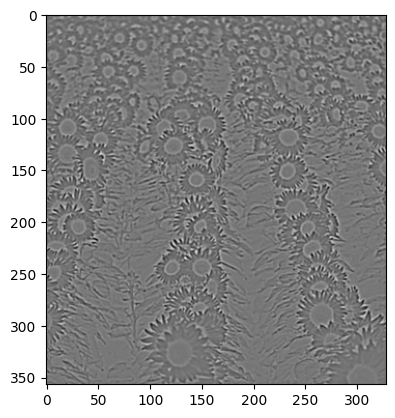

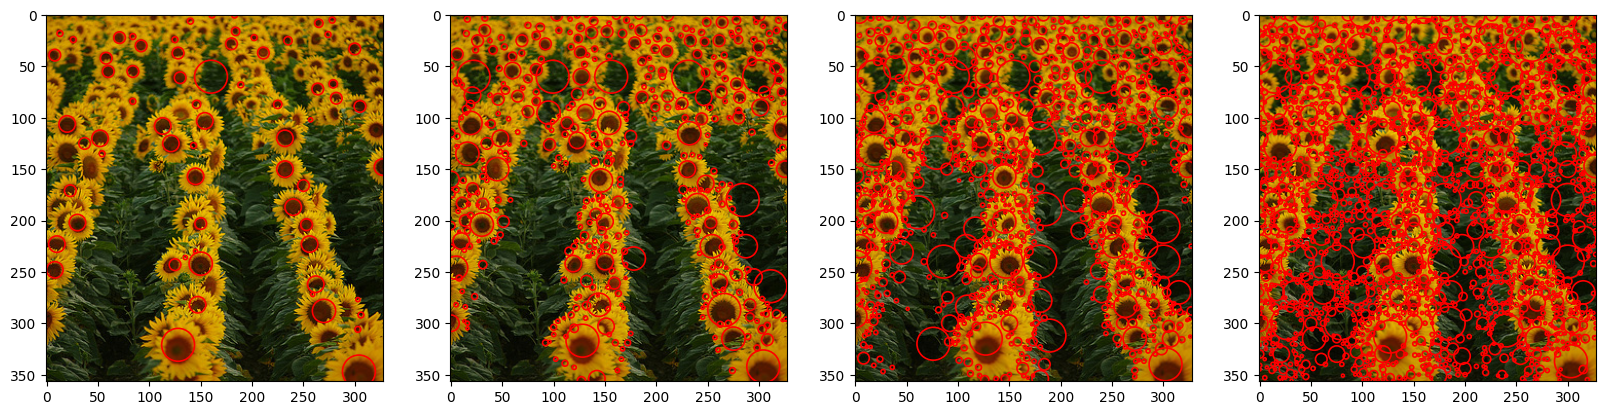

In [160]:
coordinates_diff_threshold = []

for x in [0.2,0.5,0.7,0.9]:

    log_images_np, kernels, log_images_thresholded, sigma_list = log_image(img_gray, 8, threshold=x)
    #print_steps(log_images_np, kernels, log_images_thresholded, sigma_list)


    plt.imshow(log_images_np[0], cmap="gray")

    coordinates = detect_blob_v2(log_images_thresholded)

    coordinates_1d = flatten_array_coordinates(coordinates)

    res = non_max_suppression(coordinates_1d)

    coordinates_diff_threshold.append(res)

draw_circles_multi(img, coordinates_diff_threshold)
    

    